<a href="https://colab.research.google.com/github/anna911/Capstone1/blob/master/Predicting_Sideeffect_severity_oncomments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

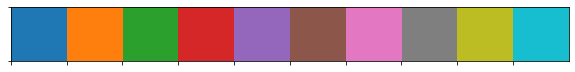

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, make_scorer, confusion_matrix
import seaborn as sns
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import chisquare
import pickle
from bs4 import BeautifulSoup
from collections import defaultdict
import requests
from statsmodels.stats.multitest import fdrcorrection_twostage
### Keras 
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding,SpatialDropout1D,LSTM,Dense

%matplotlib inline
# Imports
%matplotlib inline

import os
import numpy as np
import pandas as pd
import numpy.random as rand
from itertools import islice
from sklearn.ensemble import (GradientBoostingRegressor, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              RandomForestClassifier,
                             RandomForestRegressor)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
import seaborn as sns
import math
import sklearn.datasets as datasets
# import sklearn.cross_validation as cv
import sklearn.model_selection as cv
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import log_loss, make_scorer, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit

current_palette = sns.color_palette()
sns.palplot(current_palette)

from pylab import rcParams
rcParams['figure.figsize'] = (12, 8)

import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import re

In [0]:
from google.colab import files
uploaded = files.upload()

Saving web_scrape_old_proj_data.csv to web_scrape_old_proj_data.csv


In [0]:
df=pd.read_csv('web_scrape_old_proj_data.csv')


In [0]:
df.columns
df.drop(columns=['Unnamed: 0','0'],axis=1)

,1,2,3,4,5,6,7,8,9,10
0,3,Marginally Effective,Severe Side Effects,bipolar disorder,15mg taken daily for the period of 12 weeks,none,"Cymbalta, 90mg/daily",I didn't notice any benefit at all. Supposedl...,A very uncomfortable inner restlessness was t...,I was prescribed Abilify (15mg/daily) to assi...
1,3,Highly Effective,Moderate Side Effects,bipolar,10mg taken 1/day for the period of 8 mos,"bipolar mood disorder, acne, asthma","zoloft, wellbutrin, clonazepam, tretinoin, cl...",I had severe depression with agitation and mi...,"I became drowsy, however, with adequate sleep...",the abilify decreased the need for daily klon...
2,3,Highly Effective,No Side Effects,depression/anxiety,2 mg taken daily for the period of 3 months,anxiety,Lexapro,Within 1 week of taking the cocktail of Abili...,no side effects have been noticed,I take one pill of each 1st thing in the am.....
3,3,Considerably Effective,Extremely Severe Side Effects,depression not resolved with antidepressant d...,started out at 5mg the 10 & last 15mg taken ...,"Add, depression, poss. bipolar type 2, PTSD, ...","vyvance, ativan lisinopril, zantac, viville d...",While on abilify I can honestly say the depre...,but it caused memory loss and again an incid...,I am only taking ativan & getting psychologic...
4,3,Ineffective,Severe Side Effects,bipolar,2mg to start taken once daily for the period...,anxiety,klonopin,None due to the short time taking drug.,Headache first morning at 4AM that was reliev...,Not much to tell. I was just starting treatm...
...,...,...,...,...,...,...,...,...,...,...
7953,7,Considerably Effective,No Side Effects,"pollen, dust, mold and tree allergies",1 tab bid taken once to twice daily for the ...,obsessive compulsive disorder,"prozac, wellbutrin, yasmin",I notice the benefit of being able to be calm...,"A slightly lowered libido, tiredness in the e...",I have been on Prozac for 12 years. I was ti...
7954,7,Considerably Effective,No Side Effects,allergies,1 pill taken every 12 hours for the period ...,asthma,n/a,I benefited by being able to breathe better. ...,The side effects were sometimes being tired. ...,I took one pill first thing in the morning. ...
7955,7,Considerably Effective,Moderate Side Effects,hay fever,10mg taken 1 per day for the period of 2 months,none,none,very effective allergy relief for hay fever,"unpleasant reaction to the sudafed, much like...","Annual allergies need to be rotated, so I hav..."
7956,7,Highly Effective,Mild Side Effects,Allergies,5 mg taken twice a day for the period of 5 y...,Sinus problems,None,Zyrtec D helped me live almost symptom free e...,"While taking Zyrtec D I often had dry mouth, ...","Take one pill every 12 hours, although on mor..."


In [0]:
df['drugname']=df['0'].str.split().str.get(0)

In [0]:
df.rename(columns={"2": "effective_y/n", "3": "sideeffect", "4": "condition","5": "dosage", "6": "condition2","7": "dosage" ,"8":"benefits","9":"sideeffects-desc","10":"comments"},inplace=True)

In [0]:
df.loc[df.sideeffect == ' Mild Side Effects', 'sideeffect_label'] = 1
df.loc[df.sideeffect == ' Moderate Side Effects', 'sideeffect_label'] = 1  
df.loc[df.sideeffect == ' Severe Side Effects', 'sideeffect_label'] = 2
df.loc[df.sideeffect == ' Extremely Severe Side Effects', 'sideeffect_label'] = 2  
df.loc[df.sideeffect == ' No Side Effects', 'sideeffect_label'] = 0

In [0]:
  import nltk
  nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['comments'] = df['comments'].apply(clean_text)
df['comments'] = df['comments'].str.replace('\d+', '')

In [0]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 3000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~``', lower=True)
tokenizer.fit_on_texts(df['comments'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10950 unique tokens.


In [0]:
X = tokenizer.texts_to_sequences(df['comments'].values)
X = sequence.pad_sequences(X ,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(df['sideeffect_label']).values
print('Shape of label tensor:', df.shape)

Shape of data tensor: (7958, 100)
Shape of label tensor: (7958, 14)


In [0]:

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
sss.get_n_splits(X, Y)
     
StratifiedShuffleSplit(n_splits=5, random_state=0)
for train_index, test_index in sss.split(X, Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

TRAIN: [5082 1253  454 ... 2821 2021 7956] TEST: [6188 2728 2122 ... 6916 4835 7131]
TRAIN: [1886 4786 1145 ... 7358   64 5710] TEST: [5146 5970 4226 ... 7522 7183 3019]


In [0]:
from keras.models import Sequential
from keras.layers import Embedding,SpatialDropout1D,LSTM,Dense
from keras.layers import ReLU

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 200

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5729 samples, validate on 637 samples
Epoch 1/5





5729/5729 [==============================] - 22s 4ms/step - loss: 0.6217 - acc: 0.6754 - val_loss: 0.5994 - val_acc: 0.6609
Epoch 2/5
5729/5729 [==============================] - 20s 3ms/step - loss: 0.5863 - acc: 0.6882 - val_loss: 0.5941 - val_acc: 0.6583
Epoch 3/5
5729/5729 [==============================] - 20s 3ms/step - loss: 0.5672 - acc: 0.6980 - val_loss: 0.5613 - val_acc: 0.6855
Epoch 4/5
5729/5729 [==============================] - 20s 4ms/step - loss: 0.4756 - acc: 0.7687 - val_loss: 0.5201 - val_acc: 0.7399
Epoch 5/5
5729/5729 [==============================] - 20s 3ms/step - loss: 0.3707 - acc: 0.8339 - val_loss: 0.5114 - val_acc: 0.7509


In [0]:
ltsm_predict=model.predict(X_test,batch_size=32)

In [0]:
accr = model.evaluate(X_test,y_test)

1592/1592 [==============================] - 2s 1ms/step


In [0]:
print(accr)

[0.4783020064459374, 0.7868509355501913]


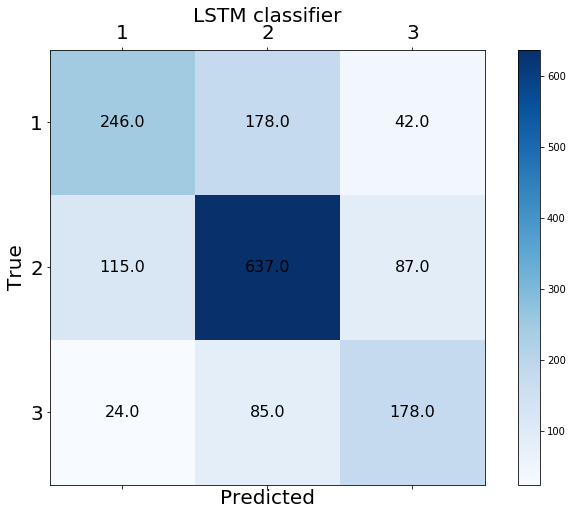

In [0]:
target_names = ['1','2','3']
lstmcm=confusion_matrix(y_test.argmax(axis=1), ltsm_predict.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(lstmcm,cmap='Blues')
plt.title('LSTM classifier',size=20)
fig.colorbar(cax)
ax.set_xticklabels([''] + target_names,size=20)
ax.set_yticklabels([''] + target_names,size=20)
plt.xlabel('Predicted',size=20)
plt.ylabel('True',size=20)
for (i, j), z in np.ndenumerate(lstmcm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',fontsize=16)

plt.show()